Vamos dar início ao projeto importando as bibliotecas utilizadas.

- Observações gerais:
Por questão de estética, no PDF do EDA, utilizarei gráficos gerados com a biblioteca Plotly, porém como a mesma não foi compatível com minha IDE, para as visualização inline, utilizarei o matploblib.

Abaixo explico qual a função principal delas:

In [4]:
#bibliotecas para cálculos e estruturas
import numpy as np
import pandas as pd
#bibliotecas para visualização dos dados
#import matplotlib.pyplot as plt
#%matplotlib inline
#import seaborn as sns

#bibliotecas para tratamento dos dados
from sklearn.model_selection import train_test_split
#from sklearn.metrics import mean_squared_error
#from sklearn.feature_selection import RFE
#from sklearn.compose import make_column_transformer
#from sklearn.preprocessing import StandardScaler, MinMaxScaler

#modelos testado e utilizado
#from xgboost import XGBRegressor
import pickle

#biblioteca para ignorar os possíveis alertas
import warnings
warnings.filterwarnings('ignore') 

Com a importação concluída, agora vamos importar os dados do CSV para o dataframe e exibir as 5 primeiros linhas.

In [5]:
df_model = pd.read_csv("../docs/rental_ny_clean.csv")
df_model.head()

,id,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,2595,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
1,3647,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365
2,3831,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,1,194
3,5022,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0
4,5099,7322,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,1,129


# Conhecendo os dados
Vamos conhecer os dados e saber quantas variáveis (colunas) e entradas (linhas) temos, utilizando a função info().

In [3]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47124 entries, 0 to 47123
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              47124 non-null  int64  
 1   host_id                         47124 non-null  int64  
 2   neighbourhood_group             47124 non-null  object 
 3   neighbourhood                   47124 non-null  object 
 4   latitude                        47124 non-null  float64
 5   longitude                       47124 non-null  float64
 6   room_type                       47124 non-null  object 
 7   price                           47124 non-null  int64  
 8   minimum_nights                  47124 non-null  int64  
 9   number_of_reviews               47124 non-null  int64  
 10  calculated_host_listings_count  47124 non-null  int64  
 11  availability_365                47124 non-null  int64  
dtypes: float64(2), int64(7), object(

Estamos com um conjunto contendo 48.894 entradas distribuídos em 16 variáveis.

Antes de fazer qualquer analise é importante ter conhecimento sobre o que cada variável se refere.
Abaixo listo as mesmas e o qual informação ela traz:

- id - Número de identificação da propriedade
- nome - Trat-se do nome da propriedade, mas para ficar mais claro, seria algo como o título do mesmo
- host_id - número de identificação do anfitrião
- host_name - Nome do anfitrião
- bairro_group - Principais regiões da cidade
- bairro - Bairros
- latitude - Latitude da propriedade
- longitude - Longitude da propriedade
- room_type - Tipo de acomodação
- price** - Preço por uma noite
- minimo_noites - Quantidade mínima de noites para reservar
- numero_de_reviews - Número de avaliações recebidas
- ultima_review - Data da última avaliação
- reviews_por_mes - Quantidade de avaliações por mês
- calculado_host_listings_count - Número de propriedades disponíveis no Airbnb pertencentes ao anfitrião
- disponibilidade_365  - Número de dias disponíveis dentro de 365 dias

Nessa breve explanação já identificamos que os nomes das variáveis precisam de um ajuste para  seguir um padrão de idioma. Atualmente estão utilizando inglês e português, como os dados se referem a imóveis em Nova Iorque e as variáveis que estão no formato string trazem os dados em inglês, adotarei o idioma inglês como padrão.

# Tratamento dos dados
Este conjunto de dados já passou pelo tratamento de dados e exploração de dados.

Uma breve conferência para confirmar se temos presença de dados nulos.

In [6]:
nulos = df_model.isnull().sum()
nulos_porcentagem = (round(nulos / df_model.shape[0] * 100, 2))
print(f"A quantidade de dados nulos é: \n{(nulos).sort_values(ascending=False)}.\n\nJá o percentual de dados nulos é: \n{(nulos_porcentagem).sort_values(ascending=False)}")

A quantidade de dados nulos é: 
id                                0
host_id                           0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64.

Já o percentual de dados nulos é: 
id                                0.0
host_id                           0.0
neighbourhood_group               0.0
neighbourhood                     0.0
latitude                          0.0
longitude                         0.0
room_type                         0.0
price                             0.0
minimum_nights                    0.0
number_of_reviews                 0.0
calculated_host_listings_count    0.0
availability_365                  0.0
dtype: float64


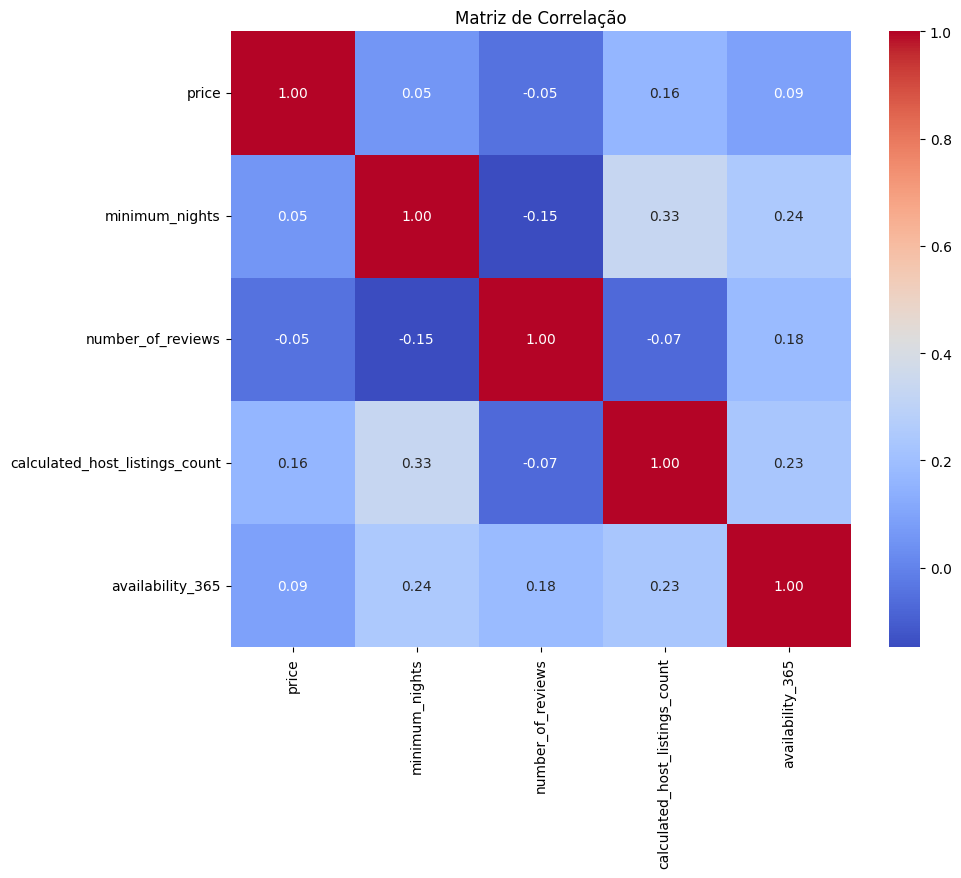

In [5]:
corr = df_model[['price', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'availability_365']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Matriz de Correlação')
plt.show()

Não existe nenhuma correlação significativa. 
Sendo assim, continuamos as análises dos dados com as variáveis room_types, neighbourhood_group e neighbourhood para entender seu comportamento no dataframe.


# Modelo para prever o preço

Neste primeiro teste, busco saber qual a baseline sem um seleção de variaveis. 
Aqui quero descobrir qual a porcentagem de acerto e depois trabalhar mais para melhorar este.

O uso dos IDs pode gerar um overfitting no modelo, tendo em vista que esse pode atribuir pesos para valores que não condizem com a sua relevância de fato. Sendo assim, estes serão removidos do dataframe. Além disso, após algumas tentativas, devido a capacidade computacional de momento, as variáveis com os nomes dos hosts e das propriedades foram removidas previamente.

In [7]:
df_model = df_model.drop(columns=['id', 'host_id'])

In [7]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47124 entries, 0 to 47123
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             47124 non-null  object 
 1   neighbourhood                   47124 non-null  object 
 2   latitude                        47124 non-null  float64
 3   longitude                       47124 non-null  float64
 4   room_type                       47124 non-null  object 
 5   price                           47124 non-null  int64  
 6   minimum_nights                  47124 non-null  int64  
 7   number_of_reviews               47124 non-null  int64  
 8   calculated_host_listings_count  47124 non-null  int64  
 9   availability_365                47124 non-null  int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 3.6+ MB


Na primeira etapa de preparação dos dados e treinamento, sabendo que modelos estatísticos tem melhor desempenho com dados númericos, vou utilizar o Get Dummies, da biblioteca Pandas para fazer esta transformação. 

Como neste primeiro momento eu busco um resultado base para o meu modelo, vou chamar de baseline, vou manter no dataframe todas as variáveis númericas atuais.  

In [8]:
df_model = pd.get_dummies(df_model, columns=['neighbourhood_group', 'neighbourhood', 'room_type'])

Este projeto vissa uma recomendação de preço, portanto utilizarei um modelo de regressão, já que no meu entendimento, um modelo de classificação tem como resultado uma saída binária, por exemplo: se uma máquina ira ou não falhar. Já para resultado contínuos, como recomendação de preço, devemos utilizar uma biblioteca de ML de regressão.

Abaixo separamos a variável alvo, price, dos demais dados e dividimos o conjunto para treino e teste.

In [9]:

X = df_model.drop('price', axis=1)
y = df_model['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Como mencionado acima, neste primeiro teste, o objetivo é ter um resultado base. 
Portanto vou testar com duas bibliotecas de ML diferentes: Random Forest e XG Boost com a mesma configuração, e comparar seu resultado no final.

Estes modelos atua de diferentes formas, o RF cria árvores de decisão de forma aleatória, efetua seu treinamento e depois combina os resultados para chegar a uma previsão final. 

Já o XG Boost é uma biblioteca que utiliza a técnica de Aumento do Gradiente, que identifica a direção da perca e segue por outro caminho, o que contribuia para a redução de erros. Além disso traz um grande poder computacional com boa velocidade e eficiência.

In [11]:
# Configuração Random Forest
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
rfe_rf = RFE(estimator=model_rf, n_features_to_select=10)
rfe_rf.fit(X_train, y_train)

# Configuração XG Boost
model_xgb = XGBRegressor(n_estimators=100, random_state=42)
rfe_xgb = RFE(estimator=model_xgb, n_features_to_select=10)
rfe_xgb.fit(X_train, y_train)

y_pred_rf = rfe_rf.predict(X_test)
y_pred_xgb = rfe_xgb.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)

print("Características selecionadas \n")
print("Random Forest:", X_train.columns[rfe_rf.support_])
print("\n")
print("XG Boost:", X_train.columns[rfe_xgb.support_])
print("\n")
print("\n")
print("Ranking das características \n")
print("Random Forest:", rfe_rf.ranking_)
print("\n")
print("XG Boost:", rfe_xgb.ranking_)
print("\n")
print("\n")
print("MSE \n")
print("Random Forest:", mse_rf)
print("\n")
print("XG Boost:", mse_xgb)


# Salvar o modelo Random Forest
with open('random_forest_regressor_model.pkl', 'wb') as file:
    pickle.dump(rfe_rf, file)

# Salvar o modelo XG Boost
with open('xgb_regressor_model.pkl', 'wb') as file:
    pickle.dump(rfe_xgb, file)

Características selecionadas 

Random Forest: Index(['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'calculated_host_listings_count', 'availability_365',
       'neighbourhood_group_Manhattan', 'neighbourhood_Midtown',
       'room_type_Entire home/apt', 'room_type_Private room'],
      dtype='object')


XG Boost: Index(['latitude', 'longitude', 'minimum_nights',
       'calculated_host_listings_count', 'neighbourhood_group_Manhattan',
       'neighbourhood_Midtown', 'neighbourhood_Tribeca',
       'neighbourhood_Upper East Side', 'neighbourhood_Williamsburg',
       'room_type_Entire home/apt'],
      dtype='object')




Ranking das características 

Random Forest: [  1   1   1   1   1   1  45  13   1  10 172  79 217 161  81  24 191 126
 109 164 198 212  85 179  11 125 165 133 159 176  38 122 153  54 131 203
  71 121 214  26 108  58  50 202  94   6  33 170  76 105  41 160  34 220
  60  69 132 166 149 178 120 103  18  43  68  40 183 207  88 134  97  42
  25 177 

Acima podemos ver que a biblioteca que melhor performou foi a Random Forest, 3906.15 contra 4153.71 do XG Boost.

Mas essa difereça foi muito pequena, portanto continuarei os testes com ambas.

# codigo alterado da primera versão 
Anteriormente, nesta parte do projeto, eu fiz um comparativo entre Random Forest e XGBoost. 

Ambos tiveram um resultado parecido, mas devido as vantagens do XGBoost em relaçao ao RF, continuei apenas com ele

Agora, sabendo que esse valores citados acima são a baseline do modelo, vou mudar um pouco os conjunto de dados, visando um melhor resultado.

Para isso vou duplicar o dataframe, preservando o original, pois ele podera ser mais eficaz no futuro do que este novo, remover os bairros do conjunto, tendo em vista que ja temos uma variável de região dos bairros, verificar como ficou o DF e conferir, por precaução, se estamos sem dados nulos.

In [10]:
df_baseline = pd.read_csv("../docs/rental_ny_clean.csv")
df_baseline.head()


,id,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,2595,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
1,3647,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365
2,3831,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,1,194
3,5022,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0
4,5099,7322,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,1,129


In [11]:
df_baseline = df_baseline.drop(columns=['neighbourhood', 'id', 'host_id'])
df_baseline.head()

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,Manhattan,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
1,Manhattan,40.80902,-73.94190,Private room,150,3,0,1,365
2,Brooklyn,40.68514,-73.95976,Entire home/apt,89,1,270,1,194
3,Manhattan,40.79851,-73.94399,Entire home/apt,80,10,9,1,0
4,Manhattan,40.74767,-73.97500,Entire home/apt,200,3,74,1,129


Abaixo utilizamos novamente o Get Dummies, porem agora somente em duas variáveis categóricas e não em 3 como no teste anterior.

In [12]:
df_baseline = pd.get_dummies(df_baseline, columns=['neighbourhood_group', 'room_type'])


Executamos os mesmos passos do teste acima

In [13]:
X = df_baseline.drop('price', axis=1)
y = df_baseline['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((37699, 14), (9425, 14), (37699,), (9425,))

Aqui não iremos modificar a configuração das bibliotecas, pois a inteção é saber se apenas removendo uma variável já conseguimos um melhor desempenho do modelo.

In [ ]:
# XG Boost
model_xgb_ajustado = XGBRegressor(n_estimators=100, random_state=42)
rfe_xgb_ajustado = RFE(estimator=model_xgb_ajustado, n_features_to_select=10)
rfe_xgb_ajustado.fit(X_train, y_train)

y_pred_xgb_ajustado = rfe_xgb_ajustado.predict(X_test)

mse_xgb_ajustado = mean_squared_error(y_test, y_pred_xgb_ajustado)

print("Características selecionadas \n")
print("XG Boost:", X_train.columns[rfe_xgb_ajustado.support_])
print("Ranking das características \n")
print("XG Boost:", rfe_xgb_ajustado.ranking_)
print("MSE \n")
print("XG Boost:", mse_xgb_ajustado)

Características selecionadas 

XG Boost: Index(['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'calculated_host_listings_count', 'availability_365',
       'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan',
       'room_type_Entire home/apt', 'room_type_Private room'],
      dtype='object')
Ranking das características 

XG Boost: [1 1 1 1 1 1 4 1 1 3 5 1 1 2]
MSE 

XG Boost: 3834.340087890625


Agora veremos com o Random Forest:

Podemos comparar que o modelo performou melhor sem a variável 

Abaixo vou exportar o mesmo para o arquivo .pkl

In [ ]:
with open('../models/model_rfe_xgb_ajustado2.pkl', 'wb') as file:
    pickle.dump(rfe_xgb_ajustado, file)

Atualização do projeto
# Hiper Tunning com Bayesian Optimization

Após alguns estudos, conheci outra biblioteca para criação de modelos: a LightGBM. Sendo asim, a partir deste ponto, irei utiliza-la  ao invés do XGBoost.

Os motivos foram:

Aqui estão as principais conclusões da nossa comparação:

No XGBoost, as árvores crescem em profundidade, enquanto no LightGBM, as árvores crescem em folhas, o que é a diferença fundamental entre as duas estruturas.

O XGBoost se beneficia de uma grande base de usuários, resultando em documentação extensa e uma riqueza de recursos para resolução de problemas. O LightGBM, embora poderoso, ainda não atingiu o mesmo nível de documentação abrangente e suporte da comunidade.

Ambos os algoritmos têm desempenho semelhante em termos de desempenho do modelo, mas o treinamento do LightGBM acontece em uma fração do tempo exigido pelo XGBoost.

O treinamento rápido no LightGBM o torna a escolha ideal para experimentos de aprendizado de máquina.

O XGBoost requer muitos recursos para treinar grandes quantidades de dados, o que o torna uma opção acessível para a maioria das empresas, enquanto o LightGBM é leve e pode ser usado em hardware modesto.

O LightGBM oferece a opção de passar nomes de recursos que devem ser tratados como categorias e lida com esse problema com facilidade dividindo por igualdade. 

In [3]:
from lightgbm import LGBMRegressor
from skopt import gp_minimize
from sklearn.metrics import roc_auc_score
from skopt.plots import plot_convergence


In [15]:
model_lgb_tunning = LGBMRegressor(random_state=0)
model_lgb_tunning.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 37699, number of used features: 14
[LightGBM] [Info] Start training from score 131.288310


LGBMRegressor(random_state=0)

In [18]:
p = model_lgb_tunning.predict(X_test)

In [21]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, p)
print("MSE:", mse)


MSE: 3817.8811129298


Acima temos o resultado do modelo sem a utilização do hipertunning, ou seja, o valor base.

In [22]:
def treinar_modelo(params):
    learning_rate = params[0]
    num_leaves = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    
    print("Hiperparâmetros:", params, '\n')
    
    model_lgb_tunning = LGBMRegressor(learning_rate=learning_rate, num_leaves=num_leaves, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree, random_state=0, subsample_freq=1, 
                         n_estimators=100)
    model_lgb_tunning.fit(X_train, y_train)
 
    p = model_lgb_tunning.predict(X_test)
    
    return mean_squared_error(y_test, p)

space = [(1e-3, 1e-1, 'log-uniform'), #learning rate
         (2, 128), # num_leaves
         (1, 100), # min_child_samples
         (0.05, 1.0), # subsample
         (0.1, 1.0)] # colsample bytree

In [23]:
resultados_gp = gp_minimize(treinar_modelo, space, random_state=1, verbose=1, n_calls=30, n_random_starts=10)

Iteration No: 1 started. Evaluating function at random point.
[0.09871192514273254, np.int64(120), np.int64(14), 0.9990884895579377, 0.3124800792567785] 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 37699, number of used features: 14
[LightGBM] [Info] Start training from score 131.288310
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [31]:
print("Melhores hiperparâmetros:", resultados_gp.x)
print("Melhor MSE alcançado:", resultados_gp.fun)

Melhores hiperparâmetros: [0.1, np.int64(128), np.int64(28), 1.0, 0.8100613986060728]
Melhor MSE alcançado: 3714.066426329695


<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

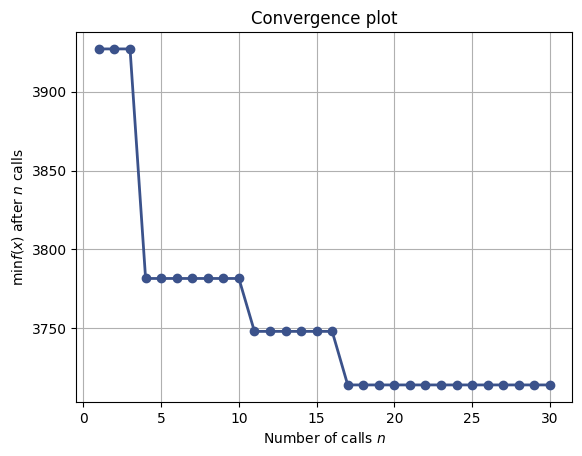

In [24]:

plot_convergence(resultados_gp)

Agora sabendo quais os hiper parametros performaram melhor, vou utilizar e seguir com o modelo.


In [32]:
# Exportar o modelo para um arquivo .pkl usando pickle
with open('../models/model_rfe_lgb_tunnig.pkl', 'wb') as f:
    pickle.dump(model_lgb_tunning, f)

## Análise dos Resultados

Quando testei diferentes métodos para prever preços, obtive alguns resultados interessantes com o MSE, que é o Erro Quadrático Médio. Esse índice mede o quanto nossas previsões erram, em média, comparadas aos valores reais. Basicamente, quanto menor o MSE, melhor o modelo está em acertar as previsões.

1. **XGBoost (MSE = 3834.34):**
   Comecei usando o XGBoost, um tipo de modelo muito apreciado por sua eficiência e precisão, mas ele teve um MSE de 3834.34.

2. **LGBMRegressor (MSE = 3817.88):**
   Depois experimentei o LGBMRegressor, outro modelo robusto, que apresentou um desempenho um pouco melhor com um MSE de 3817.88.

3. **LGBMRegressor com Ajuste Fino (MSE = 3714):**
   Por fim, melhorei o LGBMRegressor ajustando seus parâmetros, através de uma técnica chamada otimização de hiperparâmetros, e consegui reduzir o MSE para 3714. Isso mostra que ajustar os detalhes realmente pode melhorar as previsões.

### Por Que Otimizar os Parâmetros?

Otimizar os parâmetros do modelo, o tal do hiper tunning, ajuda a:

- **Melhorar as Previsões:** Com os ajustes, consegui um modelo que erra menos, como visto pela queda no MSE.
- **Prevenir o Overfitting:** Isso significa que o modelo não vai simplesmente decorar os dados com que foi treinado, mas vai aprender de verdade a fazer previsões sobre novos dados.
- **Usar Melhor os Recursos:** Um modelo bem ajustado pode ser mais rápido para treinar e usar menos memória.

# Conclusão

Experimentar com modelos diferentes e ajustar seus parâmetros provou ser uma ótima estratégia para melhorar a precisão das minhas previsões. O ajuste fino, especialmente, mostrou seu valor ao reduzir o MSE, indicando que minhas previsões estão mais próximas da realidade. Essas técnicas são incrivelmente úteis para tornar os modelos mais precisos e confiáveis!

# Sugestão do preço para a nova propriedade

Primeiro vou montar o DF com os dados da propriedade que devo sugerir o preço.

Para isso coloco as informação em um dicionário, em seguida, utilizando o pandas converto-o para um dataframe e depois, conforme feito nos tratamentos de dados, altero o padrão dos nomes das variáveis para inglês.
Após isso, verifico com as funções head() e info() se o processo teve exito

In [26]:
propriedade = {
    'id': [2595],
    'nome': ['Skylit Midtown Castle'],
    'host_id': [2845],
    'host_name': ['Jennifer'],
    'bairro_group': ['Manhattan'],
    'bairro': ['Midtown'],
    'latitude': [40.75362],
    'longitude': [-73.98377],
    'room_type': ['Entire home/apt'],
    'minimo_noites': [1],
    'numero_de_reviews': [45],
    'ultima_review': ['2019-05-21'],
    'reviews_por_mes': [0.38],
    'calculado_host_listings_count': [2],
    'disponibilidade_365': [355]
}

In [27]:
df_propriedade = pd.DataFrame(propriedade)

df_propriedade.rename(columns={
    'nome': 'name',
    'bairro_group': 'neighbourhood_group',
    'bairro': 'neighbourhood',
    'minimo_noites': 'minimum_nights',
    'numero_de_reviews': 'number_of_reviews',
    'ultima_review': 'last_review',
    'reviews_por_mes': 'reviews_per_month',
    'calculado_host_listings_count': 'calculated_host_listings_count',
    'disponibilidade_365': 'availability_365'
}, inplace=True)

df_propriedade.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              1 non-null      int64  
 1   name                            1 non-null      object 
 2   host_id                         1 non-null      int64  
 3   host_name                       1 non-null      object 
 4   neighbourhood_group             1 non-null      object 
 5   neighbourhood                   1 non-null      object 
 6   latitude                        1 non-null      float64
 7   longitude                       1 non-null      float64
 8   room_type                       1 non-null      object 
 9   minimum_nights                  1 non-null      int64  
 10  number_of_reviews               1 non-null      int64  
 11  last_review                     1 non-null      object 
 12  reviews_per_month               1 non-nu

Seguindo a lógica feita na criação do modelo, vou remover as variáveís namo, host_name, id, host_id. Além disso, como o modelo performou melhor sem a variável neighbourhood, esta tmb será removida



In [28]:
df_propriedade.drop(['host_name', 'name', 'id', 'host_id', 'neighbourhood'], axis=1, inplace=True)

Feito os ajustes necessários, vou continuar seguindo os mesmos passos realizados na criação do modelo.
Aqui para garantir o sucesso do modelo, insiro uma variável para incluir uma possível coluna faltante.
Em seguida ordeno o DF de acordo com as do treinamento. 

In [29]:
df_propriedade = pd.get_dummies(df_propriedade, columns=['neighbourhood_group', 'room_type'])

missing_cols = set(X_train.columns) - set(df_propriedade.columns)
for col in missing_cols:
    df_propriedade[col] = 0

df_propriedade = df_propriedade[X_train.columns]

# Previsão sem ajuste nos Hiper Parametros

In [32]:
preco_previsto = rfe_xgb_ajustado.predict(df_propriedade)

print("Preço previsto para a nova propriedade:", int(preco_previsto[0]))

Preço previsto para a nova propriedade: 272


# Previsão após o Hiper Tunning

In [30]:
preco_previsto = model_lgb_tunning.predict(df_propriedade)

print("Preço previsto para a nova propriedade:", int(preco_previsto[0]))

Preço previsto para a nova propriedade: 252
